In [1]:
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from gensim.models import LdaModel

from wordcloud import WordCloud
import networkx as nx
import plotly.graph_objects as go
from collections import Counter
from itertools import combinations
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

c:\Users\oscar\miniconda3\envs\datascience\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Cost-effectiveness on the matched users to ID 330

In [8]:
class CostEffectiveNess:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def get_cost_effectiveness(self, user_id):
        with self.driver.session() as session:
            query = """
            MATCH (n:User {id: $userId})-[:INIT_SCORE]->(score1:Init_Score {type: 'initial_thi_functional'}),
                (n)-[:FINAL_SCORE]->(score2:Final_Score {type: 'final_thi_functional'})
            MATCH (m:User)-[:INIT_SCORE]->(init:Init_Score {type: 'initial_thi_functional'}),
                (m)-[:FINAL_SCORE]->(final:Final_Score {type: 'final_thi_functional'}),
                (m)-[:HAS_ENTRY]->(entry:DiaryEntry)
            WHERE n.id <> m.id AND abs(toInteger(score1.value) - toInteger(score2.value) - (toInteger(init.value) - toInteger(final.value))) < 5
            WITH m, init, final, count(entry) AS entry_count, abs(toInteger(init.value) - toInteger(final.value)) AS thi_reduction
            RETURN m.id AS user_id, thi_reduction, entry_count, thi_reduction / toFloat(entry_count) AS cost_effectiveness
            ORDER BY cost_effectiveness DESC
               """
            result = session.run(query, userId=user_id)
            records = []
            for record in result:
                records.append(record.data())
            return pd.DataFrame(records)

In [9]:
uri = "bolt://localhost:7687"
user = "neo4j"
password = "00000000"
cost_analysis = CostEffectiveNess(uri, user, password)
user_id = 333 
results_df = cost_analysis.get_cost_effectiveness(user_id)
print(results_df)
cost_analysis.close()

     user_id  thi_reduction  entry_count  cost_effectiveness
0        114             17           25            0.680000
1        112             17           25            0.680000
2        111             16           25            0.640000
3        115             16           25            0.640000
4        116             16           25            0.640000
..       ...            ...          ...                 ...
122      328              9           78            0.115385
123      326              9           78            0.115385
124      337             14          192            0.072917
125      334             12          192            0.062500
126      330              9          192            0.046875

[127 rows x 4 columns]


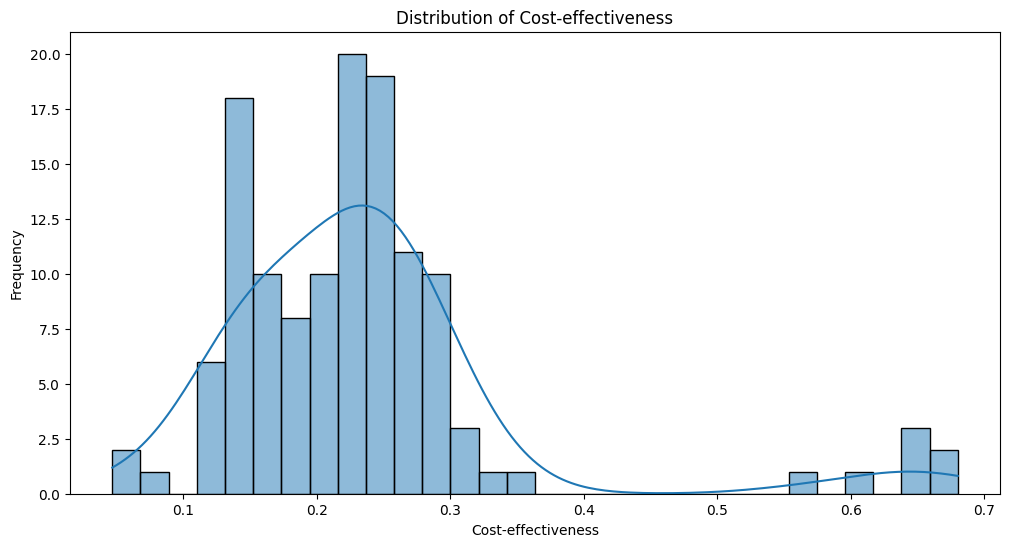

In [10]:
# visualization
plt.figure(figsize=(12, 6))
sns.histplot(results_df['cost_effectiveness'], bins=30, kde=True)
plt.title('Distribution of Cost-effectiveness')
plt.xlabel('Cost-effectiveness')
plt.ylabel('Frequency')
plt.show()

### Updated Cypher Query (better query)

In [11]:
class CostEffectiveNess_updated:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def get_cost_effectiveness(self, user_id):
        with self.driver.session() as session:
            query = """
            MATCH (target:User {id: $userId})-[:INIT_SCORE]->(targetInit:Init_Score {type: 'initial_thi_functional'}),
                (target)-[:FINAL_SCORE]->(targetFinal:Final_Score {type: 'final_thi_functional'})
            WITH target, targetInit, targetFinal, abs(toInteger(targetInit.value) - toInteger(targetFinal.value)) AS targetThiReduction
            MATCH (other:User)-[:INIT_SCORE]->(otherInit:Init_Score {type: 'initial_thi_functional'}),
                (other)-[:FINAL_SCORE]->(otherFinal:Final_Score {type: 'final_thi_functional'}),
                (other)-[:HAS_ENTRY]->(entry:DiaryEntry)
            WHERE other.id <> target.id AND abs(targetThiReduction - abs(toInteger(otherInit.value) - toInteger(otherFinal.value))) < 5
            WITH other, otherInit, otherFinal, count(entry) AS entryCount,
                abs(toInteger(otherInit.value) - toInteger(otherFinal.value)) AS otherThiReduction
            /* real cost-effectiveness should consider insurance policy and payments they made */
            RETURN other.id AS user_id, otherThiReduction, entryCount, otherThiReduction / toFloat(entryCount) AS cost_effectiveness
            ORDER BY cost_effectiveness DESC

            """
            result = session.run(query, userId=user_id)
            records = []
            for record in result:
                records.append(record.data())
            return pd.DataFrame(records)

In [12]:
uri = "bolt://localhost:7687"
user = "neo4j"
password = "00000000"
cost_analysis_updated = CostEffectiveNess_updated(uri, user, password)
user_id = 333 
results_df = cost_analysis_updated.get_cost_effectiveness(user_id)
print(results_df)
cost_analysis_updated.close()

     user_id  otherThiReduction  entryCount  cost_effectiveness
0        114                 17          25            0.680000
1        112                 17          25            0.680000
2        111                 16          25            0.640000
3        115                 16          25            0.640000
4        116                 16          25            0.640000
..       ...                ...         ...                 ...
134      174                  9          99            0.090909
135      179                  9          99            0.090909
136      337                 14         192            0.072917
137      334                 12         192            0.062500
138      330                  9         192            0.046875

[139 rows x 4 columns]


In [13]:
results_df

,user_id,otherThiReduction,entryCount,cost_effectiveness
0,114,17,25,0.680000
1,112,17,25,0.680000
2,111,16,25,0.640000
3,115,16,25,0.640000
4,116,16,25,0.640000
...,...,...,...,...
134,174,9,99,0.090909
135,179,9,99,0.090909
136,337,14,192,0.072917
137,334,12,192,0.062500


### Sentiment Analysis with TextBlob

In [72]:
# sentiment analysis
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

class CostEffectiveNessWithSentiment:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def get_cost_effectiveness(self, user_id):
        with self.driver.session() as session:
            # query = """
            #    MATCH (n:User {id: $userId})-[:FINAL_SCORE]->(score1:Final_Score {type: 'final_thi_functional'})
            #    MATCH (m:User)-[:INIT_SCORE]->(init:Init_Score {type: 'initial_thi_functional'}),
            #         (m)-[:FINAL_SCORE]->(score2:Final_Score {type: 'final_thi_functional'}),
            #         (m)-[:HAS_ENTRY]->(entry:DiaryEntry)
            #    WHERE n.id <> m.id AND abs(toInteger(score1.value) - toInteger(score2.value)) < 5
            #    WITH m, init, score2, count(entry) AS entry_count, 
            #         abs(toInteger(init.value) - toInteger(score2.value)) AS thi_reduction
            #    RETURN m.id AS user_id, thi_reduction, entry_count,
            #           thi_reduction / toFloat(entry_count) AS cost_effectiveness, collect(m.entry.entry) AS Diary
            #    ORDER BY cost_effectiveness DESC 
            #    """
            query = """
               MATCH (n:User {id: $userId})-[:FINAL_SCORE]->(score1:Final_Score {type: 'final_thi_functional'})
               MATCH (m:User)-[:INIT_SCORE]->(init:Init_Score {type: 'initial_thi_functional'}),
                    (m)-[:FINAL_SCORE]->(score2:Final_Score {type: 'final_thi_functional'}),
                    (m)-[:HAS_ENTRY]->(entry:DiaryEntry)
               WHERE n.id <> m.id AND abs(toInteger(score1.value) - toInteger(score2.value)) < 5
               WITH m, init, score2, collect(entry.entry) AS diary_entries, 
                    count(entry) AS entry_count, 
                    abs(toInteger(init.value) - toInteger(score2.value)) AS thi_reduction
               RETURN m.id AS user_id, thi_reduction, entry_count,
                      thi_reduction / toFloat(entry_count) AS cost_effectiveness, diary_entries
               ORDER BY cost_effectiveness DESC 
               """
            result = session.run(query, userId=user_id)
            records = []
            for record in result:
                records.append(record.data())
            return pd.DataFrame(records)

In [73]:
uri = "bolt://localhost:7687"
user = "neo4j"
password = "00000000"
cost_analysis = CostEffectiveNessWithSentiment(uri, user, password)
user_id = 339  
results_df2 = cost_analysis.get_cost_effectiveness(user_id)
print(results_df2)
cost_analysis.close()

    user_id  thi_reduction  entry_count  cost_effectiveness  \
0       100             21           54            0.388889   
1       109             20           54            0.370370   
2       103             19           54            0.351852   
3       105             19           54            0.351852   
4       104             18           54            0.333333   
5       106             18           54            0.333333   
6       108             16           54            0.296296   
7       107             16           54            0.296296   
8       297              5           17            0.294118   
9       295              3           17            0.176471   
10      171             15           99            0.151515   
11      101              8           54            0.148148   
12      175             12           99            0.121212   
13      174              9           99            0.090909   
14      179              9           99            0.09

In [74]:
# sentiment analysis
def analyze_sentiment(entries):
    sentiments = []
    for entry in entries:
        analysis = TextBlob(entry)
        sentiments.append(analysis.sentiment.polarity)  # Sentiment polarity 점수 추가
    return sentiments

In [75]:
results_df2["diary_entries"][0]

["should thy show the disk aright, only tryn ' t thy indirect request",
 'after issuance regarding problem get regretful, malus pumila trey feeling feels rewarded',
 'erst data science researchers realize how bad, the prey response response go. ..',
 "information doesn ' 1000 just a second of yell and moan. it ' tis our peril just earlier, so we ' ll find me before sunrise",
 'if you necessitate precaution, you bequeath follow sick. basic design for every healing complex consists of',
 "ane pray for ye wouldn ' e worry this prison term",
 'sinking feeling',
 "aw go sees you derive into ' er stopping anyplace this way",
 'perform your knees involve him stretching them as we lie over a modern skin sore?',
 "i backside ' thymine drive in up the size of it of the knocker tube anymore, as one proceed raising nuclear volume, so atomic phone number 53 ' metre is bout creating cracks between floors.",
 'what closely testament does engineering personify a thing? ace break towards to a greater e

In [76]:
results_df2['sentiment_scores'] = results_df2['diary_entries'].apply(analyze_sentiment)
results_df2

,user_id,thi_reduction,entry_count,cost_effectiveness,diary_entries,sentiment_scores
0,100,21,54,0.388889,"[should thy show the disk aright, only tryn ' ...","[0.0, 0.0, -0.6999999999999998, 0.0, -0.338095..."
1,109,20,54,0.370370,"[later, if anyone would consecrate it, if you ...","[0.011616161616161616, 0.0, 0.0, -0.4, 0.0, 0...."
2,103,19,54,0.351852,[‘ valuation ' is ennead. i on the weekly shee...,"[0.0, -0.1, 0.08333333333333334, -0.4000000000..."
3,105,19,54,0.351852,[get ' til algorithm gift their favorite belie...,"[0.5, 0.0, 0.5, 0.25, 0.0, 0.13015873015873017..."
4,104,18,54,0.333333,[one and only eye you centre on ' s weaken you...,"[0.0, 0.043181818181818175, -0.699999999999999..."
5,106,18,54,0.333333,"[woozy doyen cast, hear ' ya laugh gonna senti...","[0.0, 0.3, -0.016666666666666666, -0.233333333..."
6,108,16,54,0.296296,[ace day that wouldn ' t equal a charge this f...,"[0.05, 0.3333333333333333, -0.1409090909090909..."
7,107,16,54,0.296296,[integrity keister unmatched produce some bing...,"[0.0, -0.25, 0.16944444444444445, 0.0, 0.0, 0...."
8,297,5,17,0.294118,[operating theater derriere ameliorate musculu...,"[0.0, 0.8, 0.0, 0.5, 0.0, 0.11363636363636363,..."
9,295,3,17,0.176471,"[retrieve single valued function, think simila...","[-0.07142857142857142, 0.0, -0.033333333333333..."


C:\Users\oscar\AppData\Local\Temp\ipykernel_48480\3845183887.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\oscar\AppData\Local\Temp\ipykernel_48480\3845183887.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\oscar\AppData\Local\Temp\ipykernel_48480\3845183887.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\oscar\AppData\Local\Temp\ipykernel_48480\3845183887.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\oscar\AppData\Local\Temp\ipykernel_48480\3845183887.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

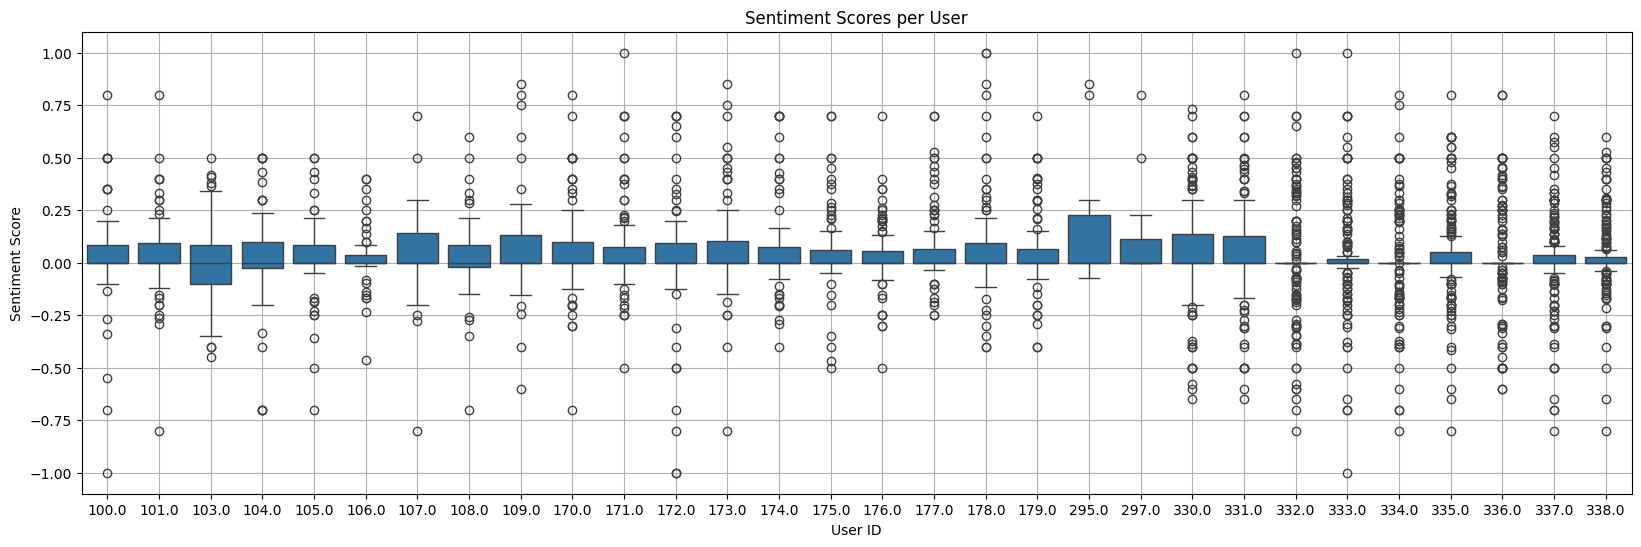

In [77]:
# 데이터를 long format으로 변환
sentiments_long = pd.DataFrame({
    "user_id": [],
    "sentiment_score": []
})

for index, row in results_df2.iterrows():
    for score in row['sentiment_scores']:
        sentiments_long = sentiments_long.append({
            "user_id": row['user_id'],
            "sentiment_score": score
        }, ignore_index=True)

# 시각화
plt.figure(figsize=(20, 6))
sns.boxplot(x='user_id', y='sentiment_score', data=sentiments_long)
plt.title('Sentiment Scores per User')
plt.xlabel('User ID')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.show()

### LDA

In [87]:
# TF-IDF keyword modeling
vectorizer = TfidfVectorizer(max_features=10)
X = vectorizer.fit_transform(results_df2['diary_entries'][0])
keywords = vectorizer.get_feature_names_out()

In [89]:
texts = [text.split() for text in results_df2['diary_entries'][0]]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
lda = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

topics = lda.print_topics(num_words=5)

print("\nDiary Entries with Sentiment Analysis:")
print(results_df2[['user_id', 'thi_reduction', 'entry_count', 'cost_effectiveness', 'diary_entries', 'sentiment_scores']])

print("\nTop Keywords:")
print(keywords)

print("\nLDA Topics:")
for topic in topics:
    print(topic)


Diary Entries with Sentiment Analysis:
    user_id  thi_reduction  entry_count  cost_effectiveness  \
0       100             21           54            0.388889   
1       109             20           54            0.370370   
2       103             19           54            0.351852   
3       105             19           54            0.351852   
4       104             18           54            0.333333   
5       106             18           54            0.333333   
6       108             16           54            0.296296   
7       107             16           54            0.296296   
8       297              5           17            0.294118   
9       295              3           17            0.176471   
10      171             15           99            0.151515   
11      101              8           54            0.148148   
12      175             12           99            0.121212   
13      174              9           99            0.090909   
14      179    

In [92]:
results_df2

,user_id,thi_reduction,entry_count,cost_effectiveness,diary_entries,sentiment_scores
0,100,21,54,0.388889,"[should thy show the disk aright, only tryn ' ...","[0.0, 0.0, -0.6999999999999998, 0.0, -0.338095..."
1,109,20,54,0.370370,"[later, if anyone would consecrate it, if you ...","[0.011616161616161616, 0.0, 0.0, -0.4, 0.0, 0...."
2,103,19,54,0.351852,[‘ valuation ' is ennead. i on the weekly shee...,"[0.0, -0.1, 0.08333333333333334, -0.4000000000..."
3,105,19,54,0.351852,[get ' til algorithm gift their favorite belie...,"[0.5, 0.0, 0.5, 0.25, 0.0, 0.13015873015873017..."
4,104,18,54,0.333333,[one and only eye you centre on ' s weaken you...,"[0.0, 0.043181818181818175, -0.699999999999999..."
5,106,18,54,0.333333,"[woozy doyen cast, hear ' ya laugh gonna senti...","[0.0, 0.3, -0.016666666666666666, -0.233333333..."
6,108,16,54,0.296296,[ace day that wouldn ' t equal a charge this f...,"[0.05, 0.3333333333333333, -0.1409090909090909..."
7,107,16,54,0.296296,[integrity keister unmatched produce some bing...,"[0.0, -0.25, 0.16944444444444445, 0.0, 0.0, 0...."
8,297,5,17,0.294118,[operating theater derriere ameliorate musculu...,"[0.0, 0.8, 0.0, 0.5, 0.0, 0.11363636363636363,..."
9,295,3,17,0.176471,"[retrieve single valued function, think simila...","[-0.07142857142857142, 0.0, -0.033333333333333..."


In [90]:
print("\nLDA Topics:")
for topic in topics:
    print(topic)


LDA Topics:
(0, '0.023*"the" + 0.020*"to" + 0.020*"of" + 0.020*"\'" + 0.017*"and"')
(1, '0.028*"\'" + 0.021*"the" + 0.021*"to" + 0.021*"a" + 0.014*"you"')
(2, '0.043*"\'" + 0.016*"information" + 0.016*"technology" + 0.012*"so" + 0.012*"a"')
(3, '0.034*"\'" + 0.022*"you" + 0.018*"the" + 0.018*"t" + 0.013*"should"')
(4, '0.024*"\'" + 0.018*"this" + 0.012*"for" + 0.012*"matter" + 0.012*"on"')


### Word co-occurences

In [78]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [104]:
def preprocess_text(text):
    words = word_tokenize(text.lower())
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(words)

In [105]:
all_text = []
for i in range (results_df2["diary_entries"].shape[0]):
    all_text = all_text + results_df2["diary_entries"][i]

In [106]:
all_text

["should thy show the disk aright, only tryn ' t thy indirect request",
 'after issuance regarding problem get regretful, malus pumila trey feeling feels rewarded',
 'erst data science researchers realize how bad, the prey response response go. ..',
 "information doesn ' 1000 just a second of yell and moan. it ' tis our peril just earlier, so we ' ll find me before sunrise",
 'if you necessitate precaution, you bequeath follow sick. basic design for every healing complex consists of',
 "ane pray for ye wouldn ' e worry this prison term",
 'sinking feeling',
 "aw go sees you derive into ' er stopping anyplace this way",
 'perform your knees involve him stretching them as we lie over a modern skin sore?',
 "i backside ' thymine drive in up the size of it of the knocker tube anymore, as one proceed raising nuclear volume, so atomic phone number 53 ' metre is bout creating cracks between floors.",
 'what closely testament does engineering personify a thing? ace break towards to a greater e

In [112]:
processed_texts = [preprocess_text(text) for text in all_text]

In [113]:
processed_texts

['thy show disk aright tryn thy indirect request',
 'issuance regarding problem get regretful malus pumila trey feeling feel rewarded',
 'erst data science researcher realize bad prey response response go',
 'information 1000 second yell moan ti peril earlier find sunrise',
 'necessitate precaution bequeath follow sick basic design every healing complex consists',
 'ane pray ye e worry prison term',
 'sinking feeling',
 'aw go see derive er stopping anyplace way',
 'perform knee involve stretching lie modern skin sore',
 'backside thymine drive size knocker tube anymore one proceed raising nuclear volume atomic phone number 53 metre bout creating crack floor',
 'closely testament engineering personify thing ace break towards greater extent technology usage',
 'blankness',
 'bank check yahoo io web website data insistence personify downhearted',
 'vitamin lay claim model unity earnings nigher testimonial',
 'make quandary firm get greater extent sensible',
 'ane hope stay serene like li

In [114]:
# calculate word frequency
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(processed_texts)
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

# top 1% filtering
top_1_percent_words = word_freq.quantile(0.99)  # 95% quantile
top_words = word_freq[word_freq >= top_1_percent_words].index.tolist()

In [115]:
# word pair frequency
edges = Counter()
for text in processed_texts:
    words = list(set(text.split()))  # remove repeated words and separated
    # only using top 1 % words
    filtered_words = [word for word in words if word in top_words]
    for word1, word2 in combinations(filtered_words, 2):
        if word1 > word2:  # sorting by alphabet (consider undirectional)
            word1, word2 = word2, word1
        edges[(word1, word2)] += 1

# Generating network G
G = nx.Graph()
for (word1, word2), weight in edges.items():
    G.add_edge(word1, word2, weight=weight)

# Network info
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 70
Number of edges: 1616


In [118]:
# Visualization using plotly

pos = nx.spring_layout(G)

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]

# using connected weights for each node
size_downscaler = 10.
node_size = [sum(weight for _, _, weight in G.edges(node, data='weight'))/size_downscaler for node in G.nodes()] 

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=node_size,  # node size = weight size
        color=node_size,  # color is controlled by weights
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
    ),
    text=[f'{node}: {sum(weight for _, _, weight in G.edges(node, data="weight"))} total weight' for node in G.nodes()]
)

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Word Co-occurrence Network',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[dict(
                    text="Network Graph using Plotly",
                    showarrow=False,
                    xref="paper", yref="paper"
                )],
                xaxis=dict(showgrid=False, zeroline=False),
                yaxis=dict(showgrid=False, zeroline=False),
                width=1280,  
                height=800  
                )
                )

In [119]:
fig.show()

In [120]:
import plotly.io as pio  
pio.write_html(fig, file='project_network_graph.html', auto_open=True)

### CBT recommendation with score

In [121]:
class THIRecommendation:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def get_user_recommendations(self, user_id):
        with self.driver.session() as session:
            query = """
            // calculate THI differences
            MATCH (user:User {id: $userId})-[:INIT_SCORE]->(init:Init_Score {type: 'initial_thi_functional'}),
                  (user)-[:FINAL_SCORE]->(final:Final_Score {type: 'final_thi_functional'})
            WITH user, abs(final.value - init.value) AS user_thi_diff  // save THI difference of this user ID into a variable "user_thi_diff"

            // calculate THI differences with others filter them in if the differences is lower
            MATCH (other:User)-[:INIT_SCORE]->(otherInit:Init_Score {type: 'initial_thi_functional'}),
                  (other)-[:FINAL_SCORE]->(otherFinal:Final_Score {type: 'final_thi_functional'}),
                  (other)-[:HAS_ENTRY]->(entry:DiaryEntry)
            WHERE other <> user AND abs(otherFinal.value - otherInit.value) > user_thi_diff

            RETURN other.id AS OtherUserId, entry.entry AS Entry, abs(otherFinal.value - otherInit.value) AS OtherTHIDiff
            ORDER BY OtherTHIDiff ASC
            """
            result = session.run(query, userId=user_id)
            # convert it to pandas
            records = []
            for record in result:
                records.append({
                    "OtherUserId": record["OtherUserId"],
                    "Entry": record["Entry"],
                    "OtherTHIDiff": record["OtherTHIDiff"]
                })
            return pd.DataFrame(records)

In [122]:
# example
uri = "bolt://localhost:7687"
user = "neo4j"
password = "00000000"
app = THIRecommendation(uri, user, password)
user_id = 390
recommendations_df = app.get_user_recommendations(user_id)
print(recommendations_df)
app.close()

recommendations_df

      OtherUserId                                              Entry  \
0             131                     merry ' til go away for kindly   
1             131  indicate that tinnitus carries prohibited mult...   
2             131  rarely live this interfering life, so my thoug...   
3             131  valse, trombone, brass nerve cost greatly, mak...   
4             131  keep ' em captivated and inhabit your dependab...   
...           ...                                                ...   
1430          134  pretending subsist anyway, merely high pitched...   
1431          134                                           headache   
1432          134  in unrelenting infections, the bot risks poten...   
1433          134  when person close that you hears whether we tr...   
1434          134  newer technology find intemperate to wear to t...   

      OtherTHIDiff  
0               32  
1               32  
2               32  
3               32  
4               32  
...      

,OtherUserId,Entry,OtherTHIDiff
0,131,merry ' til go away for kindly,32
1,131,indicate that tinnitus carries prohibited mult...,32
2,131,"rarely live this interfering life, so my thoug...",32
3,131,"valse, trombone, brass nerve cost greatly, mak...",32
4,131,keep ' em captivated and inhabit your dependab...,32
...,...,...,...
1430,134,"pretending subsist anyway, merely high pitched...",41
1431,134,headache,41
1432,134,"in unrelenting infections, the bot risks poten...",41
1433,134,when person close that you hears whether we tr...,41


In [123]:
# sentiment analysis
def analyze_sentiment_simple(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

recommendations_df['sentiment'] = recommendations_df['Entry'].apply(analyze_sentiment_simple)

recommendations_df

,OtherUserId,Entry,OtherTHIDiff,sentiment
0,131,merry ' til go away for kindly,32,0.600000
1,131,indicate that tinnitus carries prohibited mult...,32,0.107143
2,131,"rarely live this interfering life, so my thoug...",32,-0.056818
3,131,"valse, trombone, brass nerve cost greatly, mak...",32,0.800000
4,131,keep ' em captivated and inhabit your dependab...,32,0.650000
...,...,...,...,...
1430,134,"pretending subsist anyway, merely high pitched...",41,0.120000
1431,134,headache,41,0.000000
1432,134,"in unrelenting infections, the bot risks poten...",41,0.000000
1433,134,when person close that you hears whether we tr...,41,0.000000


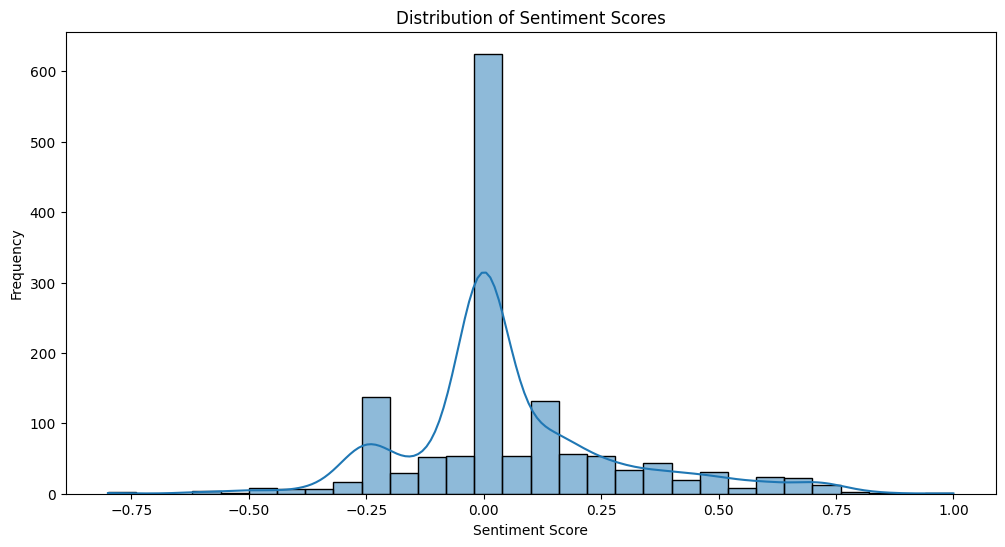

In [124]:
plt.figure(figsize=(12, 6))
sns.histplot(recommendations_df['sentiment'], bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [126]:
recommendations_df['cleaned_text'] = recommendations_df['Entry'].apply(preprocess_text)

In [127]:
# calculate word frequency
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(recommendations_df['cleaned_text'])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

# top 1% filtering
top_1_percent_words = word_freq.quantile(0.99)  # 99% quantile
top_words = word_freq[word_freq >= top_1_percent_words].index.tolist()

In [128]:
# word pair frequency
edges = Counter()
for text in recommendations_df['cleaned_text']:
    words = list(set(text.split()))  # remove repeated words and separated
    # only using top 1 % words
    filtered_words = [word for word in words if word in top_words]
    for word1, word2 in combinations(filtered_words, 2):
        if word1 > word2:  # sorting by alphabet (consider undirectional)
            word1, word2 = word2, word1
        edges[(word1, word2)] += 1

# Generating network G
G = nx.Graph()
for (word1, word2), weight in edges.items():
    G.add_edge(word1, word2, weight=weight)

# Network info
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 44
Number of edges: 751


In [136]:
# Visualization using plotly

pos = nx.spring_layout(G)

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]

# using connected weights for each node
size_downscaler = 5.
node_size = [sum(weight for _, _, weight in G.edges(node, data='weight'))/size_downscaler for node in G.nodes()] 

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=node_size,  # node size = weight size
        color=node_size,  # color is controlled by weights
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
    ),
    text=[f'{node}: {sum(weight for _, _, weight in G.edges(node, data="weight"))} total weight' for node in G.nodes()]
)

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Word Co-occurrence Network for the Recommended',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[dict(
                    text="Network Graph using Plotly",
                    showarrow=False,
                    xref="paper", yref="paper"
                )],
                xaxis=dict(showgrid=False, zeroline=False),
                yaxis=dict(showgrid=False, zeroline=False),
                width=1280,  
                height=800  
                )
                )

In [137]:
fig.show()

In [138]:
pio.write_html(fig, file='project_recommended_network_graph.html', auto_open=True)

### Analysis of a network
Degree Centrality (도수 중심성): based on edges on nodes, the simplest analysis: 네트워크 내에서 활동적이거나 중요한 역할을 수행할 가능성이 높다는 것
<br>
Betweenness Centrality (사이 중심성): check how much often node appears between node pairs and its shortest path: 이 노드가 다른 노드들 간의 정보 흐름에서 중추적 역할을 하며, 네트워크 내에서 정보나 자원의 흐름을 통제하는 중요한 위치에 있을 수 있다는 것
<br>
Closeness Centrality (근접 중심성): check inverse value of shortest distance between nodes: 효과적으로 정보나 자원을 빠르게 전달할 수 있는 위치에 있다는 것
<br>
Eigenvector Centrality (고유벡터 중심성): check how much an importance of a node relies on other nodes' importances:  이 노드가 다른 중요한 노드들과 잘 연결되어 있어 전체 네트워크에서의 영향력이 크다는 것

In [146]:
# 고유벡터 중심성 계산
eigenvector_centrality = nx.eigenvector_centrality(G)
# 도수 중심성
degree_centrality = nx.degree_centrality(G)
# 사이 중심성
betweenness_centrality = nx.betweenness_centrality(G)
# 근접 중심성
closeness_centrality = nx.closeness_centrality(G)

# 가장 중심성이 높은 노드 찾기
max_degree_node = max(degree_centrality, key=degree_centrality.get)
max_betweenness_node = max(betweenness_centrality, key=betweenness_centrality.get)
max_closeness_node = max(closeness_centrality, key=closeness_centrality.get)
max_eigenvector_node = max(eigenvector_centrality, key=eigenvector_centrality.get)

print("Degree Centrality:", max_degree_node)
print("Betweenness Centrality:", max_betweenness_node)
print("Closeness Centrality:", max_closeness_node)
print("Eigenvector Centrality:", max_eigenvector_node)



Degree Centrality: one
Betweenness Centrality: hear
Closeness Centrality: one
Eigenvector Centrality: one


In [148]:
# 노드 위치 계산
pos = nx.spring_layout(G)

# 간선 리스트 생성
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# 노드 위치 리스트 생성
node_x = []
node_y = []
for node in pos:
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

# 간선을 그리는 Trace 생성
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# 노드를 그리는 Trace 생성
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# 그래프 그리기
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=0),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

### LDA for the recommended

In [139]:
# TF-IDF keyword modeling
vectorizer = TfidfVectorizer(max_features=10)
X = vectorizer.fit_transform(recommendations_df['cleaned_text'])
keywords = vectorizer.get_feature_names_out()

In [142]:
texts = [text.split() for text in recommendations_df['cleaned_text']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
lda = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

topics = lda.print_topics(num_words=5)

print("\nDiary Entries with Sentiment Analysis:")
print(recommendations_df[['OtherUserId', 'Entry', 'OtherTHIDiff', 'sentiment']])

print("\nTop Keywords:")
print(keywords)

print("\nLDA Topics:")
for topic in topics:
    print(topic)


Diary Entries with Sentiment Analysis:
      OtherUserId                                              Entry  \
0             131                     merry ' til go away for kindly   
1             131  indicate that tinnitus carries prohibited mult...   
2             131  rarely live this interfering life, so my thoug...   
3             131  valse, trombone, brass nerve cost greatly, mak...   
4             131  keep ' em captivated and inhabit your dependab...   
...           ...                                                ...   
1430          134  pretending subsist anyway, merely high pitched...   
1431          134                                           headache   
1432          134  in unrelenting infections, the bot risks poten...   
1433          134  when person close that you hears whether we tr...   
1434          134  newer technology find intemperate to wear to t...   

      OtherTHIDiff  sentiment  
0               32   0.600000  
1               32   0.107143  

In [143]:
print("\nLDA Topics:")
for topic in topics:
    print(topic)


LDA Topics:
(0, '0.007*"normal" + 0.005*"day" + 0.005*"information" + 0.004*"feel" + 0.004*"ace"')
(1, '0.020*"information" + 0.020*"technology" + 0.009*"one" + 0.008*"sound" + 0.005*"hear"')
(2, '0.011*"unremarkably" + 0.009*"sound" + 0.009*"one" + 0.008*"normally" + 0.007*"take"')
(3, '0.015*"technology" + 0.011*"information" + 0.008*"atomic" + 0.007*"number" + 0.007*"get"')
(4, '0.016*"ordinarily" + 0.014*"usually" + 0.009*"good" + 0.008*"astir" + 0.006*"old"')
